In [2]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using SparseArrays
using ForwardDiff
using OSQP
using RobotDynamics
using RobotZoo: PlanarRocket
using RobotZoo
using StaticArrays
using Plots
using JLD2
using Test
using Statistics

const FD = ForwardDiff;

include("quadrotor.jl");

  Activating environment at `C:\Users\jonbs\Documents\JonathanStuff\CMU_Stuff\year2\OCRL\Quadrotor_MPC_with_Kalman_Filter\Project.toml`


## Quadrotor Dynamics Model

The derivation of the 3d Quadrotor Dynamics model we use is available in [Lecture 15's Notes](https://github.com/Optimal-Control-16-745/lecture-notebooks/blob/main/Lecture%2015/Lecture%2015.pdf)

$$ 
x = \begin{bmatrix} {}^{N}r \\ q \\ {}^{B}V \\ {}^{B}\omega \end{bmatrix}, \quad
\dot{x} = 
\begin{bmatrix} 
    Q {}^{B}V \\
    \frac{1}{2} L(q) H {}^{B}\omega \\
    \frac{1}{m} {}^{B}F - {}^{B}\omega \times {}^{B}V \\
    J^{-1} ({}^{B}\tau - {}^{B}\omega \times J {}^{B}\omega)
\end{bmatrix}
$$

Where:
$$
{}^{B}F = Q^T
\begin{bmatrix}
0 \\ 0 \\ -mg
\end{bmatrix}
+ 
\begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    k_T & k_T & k_T & k_T
\end{bmatrix} u
$$

$$
{}^{B}\tau = 
\begin{bmatrix}
    0 & s k_T & 0 & -s k_T \\
    -s k_T & 0 & s k_T & 0 \\
    k_m & -k_m & k_m & -k_m
\end{bmatrix} u
$$

Note that a rotation matrix $Q$ can be obtained from a quaternion $q$ via:
$$ 
Q = R^T(q) L(q)
$$

Such that:
$$
\begin{bmatrix} 0 \\ {}^{N}x \end{bmatrix} = Q \begin{bmatrix} 0 \\ {}^{B}x \end{bmatrix}
$$

For more information on the quaternion math, check out `src/quaternions.jl`

The model is defined like so:
![quad_dyn](../media/quadrotor_dynamics_image.png)
![quad_dyn_axes](../media/quadrotor_dynamics_axes_definition.png)

# LQR Controller (baseline)

The LQR formulation we used is a simple linearlization of the system about hover (i.e. all thrust vectors point straight down and sum to counter gravity).

This linearization gives us the following approximation of the system's dynamics:

$$x_{t+1} = A x_{t} + B u_{t}$$

Where A is the state Jacobian and B is the input Jacobian:
$$A = \frac{\partial x_{t+1}}{\partial x_{t}}, \quad B = \frac{\partial x_{t+1}}{\partial u_{t}}$$

This works so long as the quadrotor stays close to the point its dynamics were linearized about.

In [3]:
include("quaternions.jl")
include("dynamics.jl")
include("LQR_controller.jl")

nx = 13
nu = 4
dt = 0.025
T = 5.0
N = Int(T / dt)

model = Quadrotor()

x0 = zeros(nx)
# x0[4:7] .= [  0.9045898, 0.1836784, -0.3379966, 0.1836784] # quat version of (10, 10, 10) [deg] euler angles
x0[4] = 1.0 # enforce unit-norm constraint on quat
uhover = fill(mass * g / nu, nu) 

Q = diagm(ones(nx-1))
# Q[1:3,1:3] .= 100.0*I(3)
# Q[4:6,4:6] .= 1e5*I(3)
R = diagm(ones(nu))

Uref = [copy(uhover) for i = 1:N-1];
tref = LinRange(0.0, T, N);

# x_dot = dynamics(x0, uhover)
A, B = dynamics_jacobians(x0, uhover, dt)
J_attitude = attitude_jacobian(x0)
Ã = J_attitude'*A*J_attitude
B̃ = J_attitude'*B
K_LQR = lqr(Ã, B̃, Q, R, tol=1e-3);

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(13),), b has dims (Base.OneTo(16),), mismatch at 1")

In [4]:
include("quadrotor.jl")
include("dynamics.jl")
X_LQR = [zeros(nx) for i = 1:N]
U_LQR = [copy(uhover) for i = 1:N-1]

# X_line = line_reference(N, dt)
X_line = flip_reference(N, dt)
X_LQR[1][1:4] .= X_line[1][1:4]
# println(X_LQR[1])
# X_LQR[1][4] = 1.0

vals_ref = zeros(N,3)
vals_ref[1,:] .= X_line[1][1:3]
vals_act = zeros(N,3)
vals_act[1,:] .= X_LQR[1][1:3]

for k = 1:N-1
    
    dϕ = ϕ(quat_L(X_line[k][4:7])' * X_LQR[k][4:7])
    dX = vcat([(X_LQR[k] - X_line[k])[1:3]' dϕ' (X_LQR[k] - X_line[k])[8:end]'])'
    
    U_LQR[k] .= U_LQR[k] - (K_LQR * dX)[:,1]
    X_LQR[k+1] .= rk4(X_LQR[k], U_LQR[k], dt)[:,1]
    
    vals_ref[k+1,:] .= X_line[k+1][1:3]
    vals_act[k+1,:] .= X_LQR[k+1][1:3]

end

plot(tref, vals_ref, line=:dash, label=["x_ref" "y_ref" "z_ref"], title="LQR Controller Trajectory Following",
    xlabel="Time [sec]", ylabel="Position [m]")
plot!(tref, vals_act, label=["x_act" "y_act" "z_act"])

LoadError: DimensionMismatch("Sizes ((13,), Size(16,)) of input arrays do not match")

In [5]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\jonbs\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [6]:
include("quadrotor.jl");
# line_ref = line_reference(N, dt)
flip_ref = flip_reference(N, dt)
# visualize!(vis, model, dt*(N-1), flip_ref)
plot(tref, vals_act, line=:dash, label=["x_ref" "y_ref" "z_ref"], title="LQR Controller Trajectory Following",
    xlabel="Time [sec]", ylabel="Position [m]")
visualize!(vis, model, dt*(N-1), X_LQR)

# MPC Controller

The MPC controller works by solving the following QP:
$$ \begin{align}
    &\text{minimize}_{z} && \frac{1}{2} z^T P z\\
    &\text{subject to} && D z = d \\
    &&& C z \leq d \\
\end{align} $$

where $z$ is the concatenated vector of changes in states and controls from the reference trajectory at each time step. Since we've linearized our system about the point $(x_\text{eq}, u_\text{eq})$, these state and controls are defined relative to this reference. The equality constraints are just the linearized dynamics constraints:

$$ 
\begin{bmatrix} 
    B_k & -I \\ 
      & A_{k+1} & B_{k+1} & -I \\
      &   &   &   & \ddots \\
      &   &   &   & & A_{k+N-1} & B_{k+N-1} -I \\
\end{bmatrix}
\begin{bmatrix} \Delta u_k \\ \Delta x_{k+1} \\ \Delta u_{k+1} \\ \vdots \\ \Delta x_{k+N-1} \\ \Delta u_{k+N-1} \\ \Delta x_{k+N} \end{bmatrix} = 
\begin{bmatrix} -A_k (x_k - x_{ref,k}) \\ 0 \\ \vdots \\ 0 \end{bmatrix}
$$

And the inequality constraints limit the thrust the quadrotor can generate:

$$ 
\begin{bmatrix} u_{min} - u_k \\ u_{min} - u_{k+1} \\ \vdots \\ u_{min} - u_{k+N-1} \end{bmatrix} \leq 
\begin{bmatrix}
    I(m) \\
    0(n+m) & I(m) \\
    & 0(n+m) & I(m) \\
    &&& \ddots \\
    &&&& I(m) & 0(n)
\end{bmatrix}
\begin{bmatrix} \Delta u_k \\ \Delta x_{k+1} \\ \Delta u_{k+1} \\ \vdots \\ \Delta x_{k+N-1} \\ \Delta u_{k+N-1} \\ \Delta x_{k+N} \end{bmatrix} \leq 
\begin{bmatrix} u_{max} - u_k \\ u_{max} - u_{k+1} \\ \vdots \\ u_{max} - u_{k+N-1} \end{bmatrix}
$$

The cost matrix $P$ is defined as:
$$
P = \begin{bmatrix}
R \\
& Q \\
&& \ddots \\
&&& R \\
&&&& Q_f
\end{bmatrix}
$$

In [7]:
include("dynamics.jl")
include("quadrotor.jl")
include("quaternions.jl")

const n = state_dim(model)
const m = control_dim(model)

line_ref = line_reference(N, dt)
flip_ref = flip_reference(N, dt)
flip_ref = simple_flip_reference(N, dt)

Uref = [copy(uhover) for i = 1:N]
umin = -5*uhover[1]
umax = 5*uhover[1]

A = []
B = []

for i=1:N
#     angle = angle_of_rotation_q(flip_ref[1][4:7])
#     thrust_des = uhover / cos(angle*2)
#     clamp!(thrust_des, umin, umax)
#     Uref[i] = thrust_des
    
    # linearize state dynamics about trajectory
    A_i, B_i = dynamics_jacobians(flip_ref[i],Uref[i],dt)
    # convert state linearizations to 3 parameter attitude rep
    J_attitude = attitude_jacobian(flip_ref[i])
    Ã_i = J_attitude'*A_i*J_attitude
    B̃_i = J_attitude'*B_i
    push!(A, Ã_i)
    push!(B, B̃_i) 
end

In [208]:
include("MPC.jl")
include("quaternions.jl")
include("quadrotor.jl")
include("kalman_filter.jl")
include("dynamics.jl")

# NOTE: these are defined above by LQR 
nx = 16

Q = 1.0*I(nx-1)
# Q[1:3,1:3] *= 10
# Q[4:7,4:7] *= 10 # attitude
# Q[1:2] *= 0.05 
# Q[8:end] *= 10 # vel and angular vel
# Q[11,11] *= 0.01 # x angular vel
R = 1e-5*I(nu)
Qf = 1.0*I(nx-1)
# Qf[1:3,1:3] *= 1e3
Nmpc = 50

x0 = zeros(nx)
for i=1:7
    x0[i] = flip_ref[1][i]
end

# x0[14:16] .= 1.0


mpc = build_MPC_QP(flip_ref, Uref, tref, A, B, Q, R, Qf);
X_mpc_true, X_mpc_KF, U_mpc, t_mpc, wind_hist = simulate(model, x0, mpc, A, B, tf=T, online_linearization=false, wind_disturbance=true);

Beginning simulation...
1
[0.024999999999999998 0.0 0.0; 0.0 0.024999999999999998 0.0; 0.0 0.0 0.024999999999999998]
0.0004420839324299808
2
[0.02499996962381959 1.6826264643940562e-5 3.514910750599885e-5; -1.68795930484008e-5 0.02499996579723887 3.773541941877081e-5; -3.5123528653281886e-5 -3.775922862584108e-5 0.024999946687788106]
59.287596663486205
3
[0.024999855735357516 3.855006771697828e-5 7.851821623953688e-5; -3.7396680582775696e-5 0.024997298560041407 -0.0003650017162443298; -7.907398092186181e-5 0.00036488190041192433 0.02499720310535775]
46.4848547050934
4
[0.024999569317818743 6.67018931180298e-5 0.00013200301124658933; -6.237631607351163e-5 0.024986715831731225 -0.0008122786066071391; -0.00013410108799561903 0.000811934946182153 0.024986444921835077]
42.28699928796246
5
[0.024998980997751958 0.00010500907506478484 0.00020048611843736828; -9.348639717594692e-5 0.024959689872906567 -0.0014159295450949616; -0.00020611119984301717 0.0014151217080348665 0.02495905965475785]
40

39
[0.024191577630902135 0.005212384100743647 0.003549453683876296; -0.004037794550990709 0.023611769756301776 -0.007154057451496138; -0.004843943113073084 0.006349438849340241 0.023690099909567434]
40.394461192266434
40
[0.024128767155216523 0.005390482550474533 0.0037074642235726644; -0.004259568274813346 0.02369674672420665 -0.006732032903765444; -0.004965749831491952 0.00586573828949789 0.023789376533511614]
40.39977893448665
41
[0.024065186032901115 0.005560583196959084 0.0038661602364018104; -0.0045654910398393676 0.02386091503356028 -0.005900213257109732; -0.005002347246012243 0.004973550792469659 0.023984157974200747]
40.39919135257179
42
[0.02400036801948613 0.005722612450997464 0.00402919381376865; -0.0048821349499161785 0.024001696501855047 -0.005008280519053496; -0.005014714881854795 0.004021179387274985 0.024159518317755202]
40.40110222962138
43
[0.023934684659291855 0.005874305113708794 0.004198055452124285; -0.005224460744900912 0.02412361373746083 -0.003969366435781547;

40.29170440083403
77
[0.0240268483931803 0.002663386628204987 0.006373130595369964; -0.005103284884846724 -0.008699650064691084 0.02287511633590293; 0.004654769005418131 -0.02328563572735987 -0.007817327216291478]
40.29728011175184
78
[0.02408397760476671 0.002257381943975479 0.0063139636562164385; -0.004799284975500345 -0.010636948558108875 0.022109290442392713; 0.0046828153016689866 -0.02251128771096108 -0.00981384932885778]
40.292143192669485
79
[0.0241413473172907 0.0018420020142987815 0.006229147848844135; -0.004521316654011176 -0.0124484223748859 0.021203612146609558; 0.004664005392603632 -0.021601909217070395 -0.01168773724350895]
40.28879913555888
80
[0.024197192414160053 0.0014329553359047269 0.006119022471336024; -0.004266469675128363 -0.014127155786853071 0.020179681531712783; 0.0046144387732775585 -0.02057593072312485 -0.01342895430713298]
40.28298406046859
81
[0.02425059925854674 0.0010360018741594453 0.0059862395521217086; -0.004035067635351528 -0.01566880683027768 0.0190

[0.02499934872106029 -0.00013047589084848744 -0.00011074304263700247; 0.00010237497000290671 0.024369739986810975 -0.00557310912368553; 0.0001371378514016567 0.005572516689628386 0.024369702854875136]
40.70242921210388
118
[0.02499798748181098 0.0002498327694422721 0.00018908140141184822; -0.0002429199895275689 0.02498157157644957 -0.0009084732237771836; -0.00019793911587660682 0.0009065573859293862 0.024982035315921764]
40.76722634362031
119
[0.024987213348623624 0.0005781991033178599 0.0005509914407075764; -0.0006483589510365959 0.02475603667859301 0.0034192588461416417; -0.00046647434592311067 -0.0034318089207833313 0.02475839166289088]
40.82649723656377
120
[0.024967386466263453 0.00084839134377082 0.000953816307695889; -0.0010886533670291581 0.02390645057370171 0.007230352168636986; -0.0006666870743457618 -0.007262459697788483 0.023912204700486803]
40.86358107931001
121
[0.02493957580646853 0.0010610137762508162 0.0013756982518993732; -0.0015408003178026127 0.022654484657781207 0.

[0.024568085958841475 0.004486367515847039 -0.0011319976904088612; -0.002332835013553034 0.017292338408455392 0.017903412640975003; 0.003995849433006946 -0.017488475701413226 0.017412226628786984]
40.34420189062271
157
[0.024550663023287678 0.00446259830881984 -0.0015329322462595207; -0.0022818346783853253 0.01833741995538543 0.016838393195857962; 0.004130123277807357 -0.0163958362041423 0.018415152138421535]
40.3427617292156
158
[0.024532205900066634 0.004407715964137561 -0.001934581440141023; -0.00224494307063234 0.019364431390186003 0.015651779275843353; 0.004258030195934507 -0.015185189444034384 0.01939789518724275]
40.34077790199194
159
[0.024513137790036114 0.004320203841761658 -0.0023327206201140356; -0.0022217191970740208 0.02035275711500722 0.01434671889209646; 0.004378325842025573 -0.013860021410050093 0.0203403329533532]
40.337785003120565
160
[0.024493947029528527 0.004199224273077326 -0.002722632894060441; -0.00221180150141891 0.021283291327710733 0.012927817946521274; 0.0

195
[0.02412752782903644 -0.004504314311337576 -0.004751148451824425; 0.004397099996142408 0.02459060179912803 -0.00098346664012963; 0.004850538443275624 0.00011349410713251322 0.024524656748899715]
40.28312459882605
196
[0.024094888177460767 -0.0046958571793410345 -0.004731287750553868; 0.004802653602511652 0.02453410437360887 0.00010795971145214327; 0.0046228384479635835 -0.0010129603817149258 0.02454796714889118]
40.28371375509827
197
[0.024058932336177688 -0.004882231583777971 -0.004725604371474139; 0.005205626350786888 0.02441876303354107 0.0012747114729815966; 0.004366799684516412 -0.0022107172645384554 0.024516182684940588]
40.28859245050702
198
[0.024021208540823697 -0.005060558418621609 -0.004729905504046552; 0.005598704356804131 0.024236095989321797 0.002503113082173081; 0.004078692249600612 -0.0034643662700207505 0.024420521129275848]
40.28997617304414
199
[0.023982144317374113 -0.005230013010971727 -0.004743776220610085; 0.005975859945777996 0.023980318147790964 0.003772644

In [209]:
visualize!(vis, model, dt*(N-1), X_mpc_KF)

In [156]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat C:\Users\jonbs\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8702))

In [211]:
include("quadrotor.jl")
visualize!(vis, model, dt*(N-1), X_mpc_KF)
# visualize!(vis, model, dt*(N-1), flip_ref)

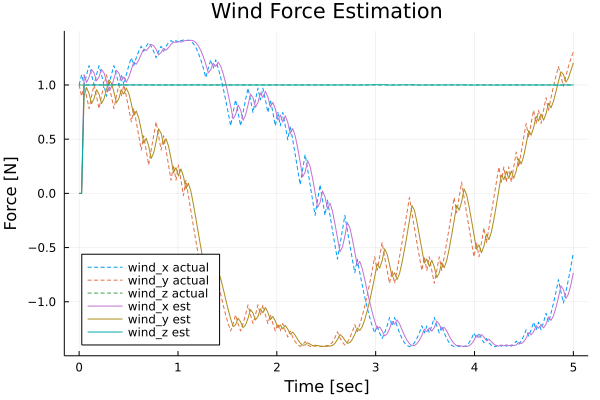

In [212]:
include("plotter.jl")
plot_wind_tracking(X_mpc_KF, wind_hist)

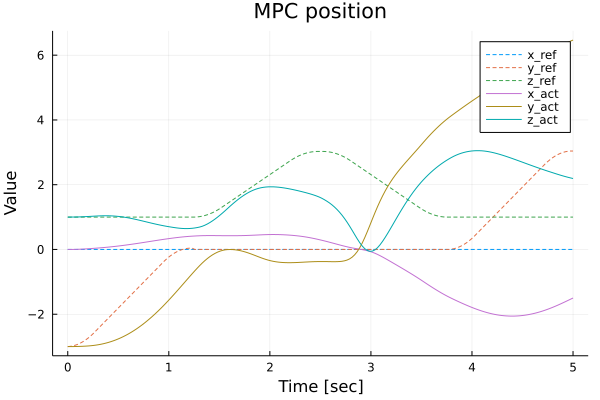

In [159]:
include("plotter.jl")
labs = ["x", "y", "z"]
indices = 1:3
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC position")

In [128]:
ω = [1 2 3]
test = hat(ω)
a = exp.(test)

3×3 Matrix{Float64}:
  1.0       0.0497871  7.38906
 20.0855    1.0        0.367879
  0.135335  2.71828    1.0

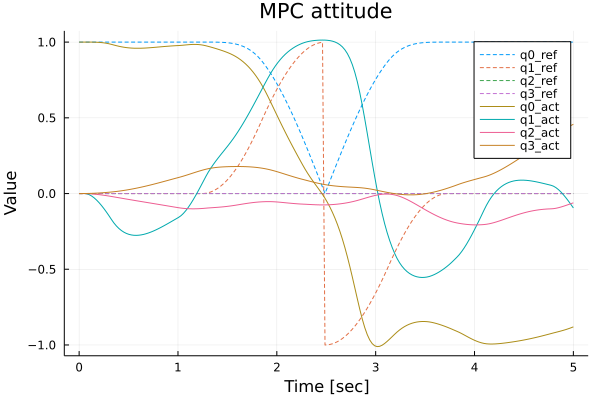

In [113]:
labs = ["q0", "q1", "q2", "q3"]
indices = 4:7
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC attitude")

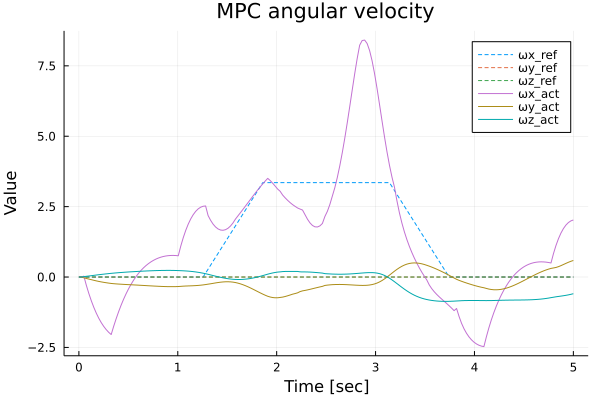

In [116]:
labs = ["ωx", "ωy", "ωz"]
indices = 11:13
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC angular velocity")

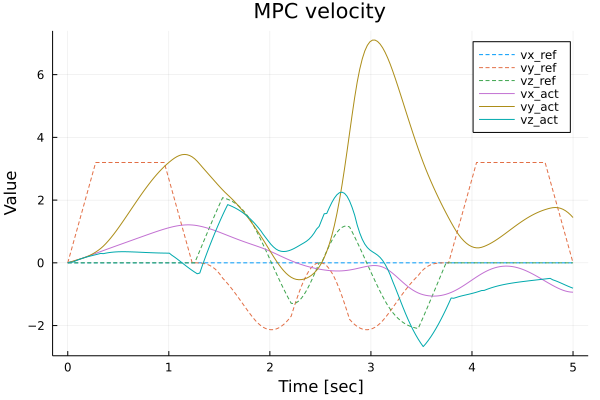

In [117]:
labs = ["vx", "vy", "vz"]
indices = 8:10
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC velocity")